# 图卷积网络

In [1]:
import numpy as np
D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [2]:
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [3]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [4]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
print(np.linalg.inv(D + np.identity(4)) @ A)

print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]
[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


## 比较图卷积层和图线性层

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
dataset = Planetoid(root='.', name='Cora')
data = dataset[0] #取出其中的图


In [7]:
degrees = degree(data.edge_index[0]).numpy() # 统计节点度数，并转化外numpy矩阵

In [8]:
numbers = Counter(degrees)

<BarContainer object of 37 artists>

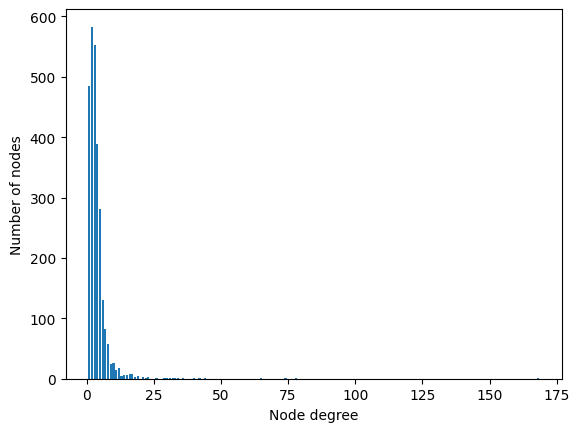

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

### 实现图卷积网络

In [10]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [11]:
def accuracy(pred, y):
    return ((pred == y).sum() / len(y)).item()

In [12]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask]) # argmax 返回最大值的索引
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc
                
                

In [13]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch: 000, Loss: 1.9327, Accuracy: 0.1714, Val Loss: 1.9443, Val Accuracy: 0.1340
Epoch: 020, Loss: 0.0887, Accuracy: 1.0000, Val Loss: 0.7767, Val Accuracy: 0.7580
Epoch: 040, Loss: 0.0146, Accuracy: 1.0000, Val Loss: 0.7670, Val Accuracy: 0.7640
Epoch: 060, Loss: 0.0152, Accuracy: 1.0000, Val Loss: 0.7509, Val Accuracy: 0.7700
Epoch: 080, Loss: 0.0174, Accuracy: 1.0000, Val Loss: 0.7400, Val Accuracy: 0.7660
Epoch: 100, Loss: 0.0161, Accuracy: 1.0000, Val Loss: 0.7373, Val Accuracy: 0.7680


In [14]:
acc = gcn.test(data)
print(f'GCN Accuracy: {acc:.4f}')

GCN Accuracy: 0.7930


In [15]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root='.', name='Chameleon', transform=T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

In [16]:
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print('Number of nodes: ', data.x.shape[0])
print('Number of unique feature: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)


WikipediaNetwork()
------------
Number of graphs: 1
Number of nodes:  2277
Number of unique feature:  2325
Number of classes:  5


In [17]:
import pandas as pd
df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')

In [18]:
values = np.log10(df['target'])

In [19]:
data.y = torch.tensor(values)

<BarContainer object of 63 artists>

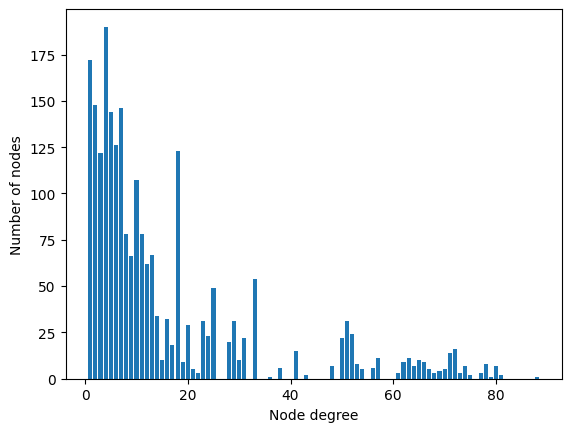

In [20]:
degrees = degree(data.edge_index[0]).numpy() # 统计节点度数，并转化外numpy矩阵
numbers = Counter(degrees)
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_67394/2583017776.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'], fit=norm)


<Axes: xlabel='target', ylabel='Density'>

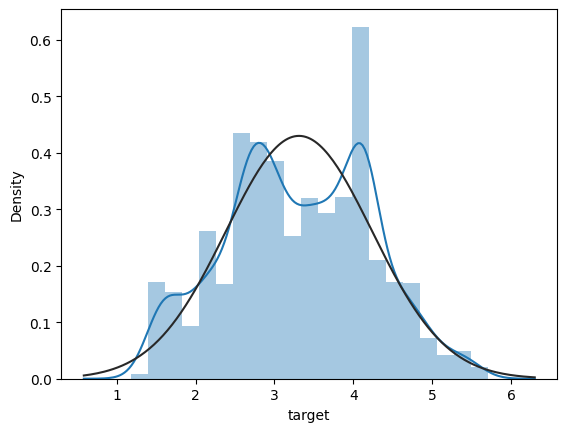

In [21]:
import seaborn as sns
from scipy.stats import norm
df['target'] = values
sns.distplot(df['target'], fit=norm)

### 定义GCN类

In [22]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
        
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())
    
    

In [23]:
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)
gcn.fit(data, epochs=300)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 000, Loss: 11.5593, Val Loss: 11.4610
Epoch: 020, Loss: 10.7826, Val Loss: 10.6863
Epoch: 040, Loss: 4.2282, Val Loss: 3.9311
Epoch: 060, Loss: 0.8113, Val Loss: 0.9697
Epoch: 080, Loss: 0.5583, Val Loss: 0.7338
Epoch: 100, Loss: 0.4813, Val Loss: 0.7074
Epoch: 120, Loss: 0.4740, Val Loss: 0.7612
Epoch: 140, Loss: 0.4464, Val Loss: 0.7226
Epoch: 160, Loss: 0.4250, Val Loss: 0.7737
Epoch: 180, Loss: 0.3912, Val Loss: 0.7370
Epoch: 200, Loss: 0.3880, Val Loss: 0.6996
Epoch: 220, Loss: 0.3615, Val Loss: 0.7446
Epoch: 240, Loss: 0.3228, Val Loss: 0.7912
Epoch: 260, Loss: 0.3092, Val Loss: 0.7376
Epoch: 280, Loss: 0.3126, Val Loss: 0.7644
Epoch: 300, Loss: 0.2856, Val Loss: 0.8026


In [24]:
loss = gcn.test(data)
print(f'GCN Accuracy: {loss:.4f}')

GCN Accuracy: 0.8196


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask].numpy(), y_pred)
mae = mean_absolute_error(data.y[data.test_mask].numpy(), y_pred)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')





MSE: 0.8196, MAE: 0.6825


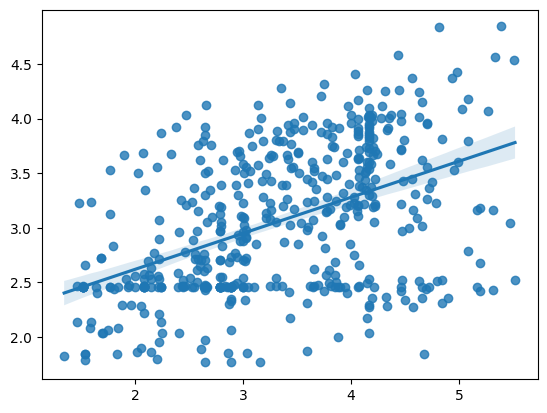

In [27]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)